**Data Preprocessing for Naive Bayes**

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

DATASET = 'hf://datasets/google-research-datasets/go_emotions/'
TRAIN_PATH = 'simplified/train-00000-of-00001.parquet'
VAL_PATH = 'simplified/validation-00000-of-00001.parquet'
TEST_PATH = 'simplified/test-00000-of-00001.parquet'

# Loads df and also removes duplicate entries
def load_df(path):
  df = pd.read_parquet(DATASET + path)
  df = df[df['labels'].apply(len) == 1] # Remove rows with more than one label
  df.reset_index(drop=True, inplace=True) # Reset indexing
  return df

vectorizer = CountVectorizer(stop_words='english')

df_train = load_df(TRAIN_PATH)
x_train = vectorizer.fit_transform(df_train['text']).toarray() # numpy array count
y_train = np.array(df_train['labels'], dtype=int)

df_test = load_df(TEST_PATH)
x_test = vectorizer.transform(df_test['text']).toarray()
y_test = np.array(df_test['labels'], dtype=int)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


**Naive Bayes Class**

In [111]:
import numpy as np

class NaiveBayes:

    def __init__(self, laplace=1):
        self.laplace = laplace
        self._classes = None
        self._log_priors = None
        self._log_parameters = None
        pass

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self._classes = np.unique(y)

        # log(P(c)) = log(rows in class c / total rows)
        self._log_priors = np.array([
            np.log(X[y == c].shape[0] / float(n_samples))
            for c in self._classes
        ])

        # Compute log-conditional probabilities for each feature given a class:
        # log(P(x|c)) = log((sum of feature values in class c + laplace) / (total sum of values in class c + laplace * n_features))
        self._log_parameters = np.array([
            np.log((np.sum(X[y == c], axis=0) + self.laplace) / (np.sum(X[y == c]) + self.laplace * n_features))
            for c in self._classes
        ])

    def predict(self, X):
        # Compute log-posterior probabilities for each class:
        # log(P(c|x)) = X @ log(P(x|c))^T + log(P(c))
        log_probs = X @ self._log_parameters.T + self._log_priors
        return np.argmax(log_probs, axis=1)

    def evaluate_acc(self, X, y):
        y_pred = self.predict(X)
        accuracy = np.sum(y_pred == y) / y_pred.shape[0]
        return accuracy

**Finding best Laplace**

Training models: 100%|██████████| 49/49 [04:01<00:00,  4.94s/Laplace]


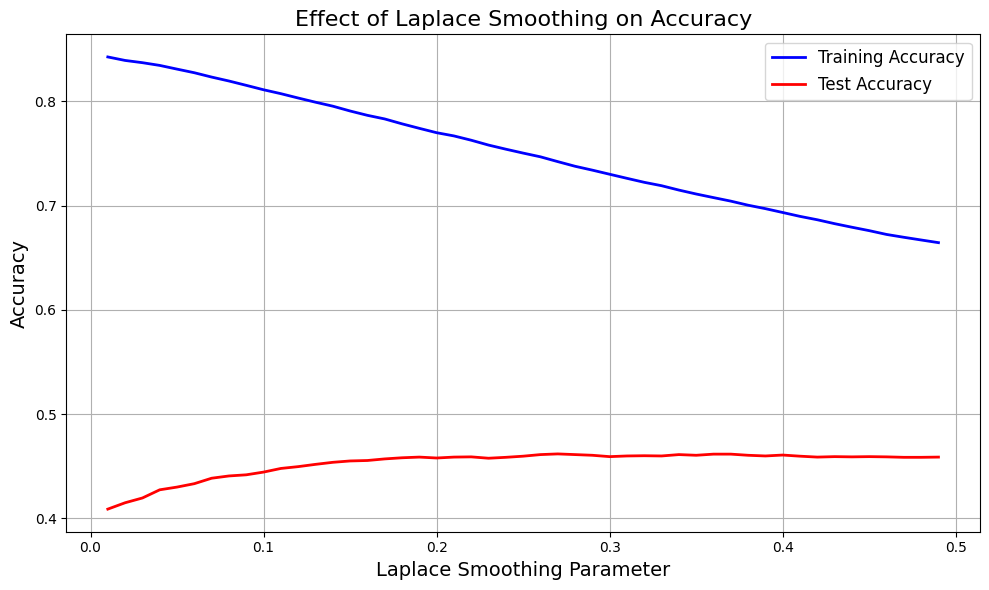

Highest test accuracy: 0.4619 with a training accuracy of: 0.7422 at Laplace smoothing value: 0.27


In [128]:
import matplotlib.pyplot as plt
from tqdm import tqdm

laplace_testing = [0.01 + 0.01 * i for i in range(0, 49)]
train_accs = []
test_accs = []

for laplace in tqdm(laplace_testing, desc='Training models', unit='Laplace'):
  model = NaiveBayes(laplace)
  model.fit(x_train, y_train)
  train_accs.append(model.evaluate_acc(x_train, y_train))
  test_accs.append(model.evaluate_acc(x_test, y_test))

plt.figure(figsize=(10, 6))
plt.plot(laplace_testing, train_accs, label='Training Accuracy', color='blue', linestyle='-', linewidth=2)
plt.plot(laplace_testing, test_accs, label='Test Accuracy', color='red', linestyle='-', linewidth=2)

plt.xlabel('Laplace Smoothing Parameter', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Effect of Laplace Smoothing on Accuracy', fontsize=16)
plt.legend(fontsize=12)

plt.grid(True)
plt.tight_layout()
plt.show()

max_test_acc = max(test_accs)
best_laplace = laplace_testing[test_accs.index(max_test_acc)]
best_train_acc = train_accs[test_accs.index(max_test_acc)]

print(f"Highest test accuracy: {max_test_acc:.4f} with a training accuracy of: {best_train_acc:.4f} at Laplace smoothing value: {best_laplace}")

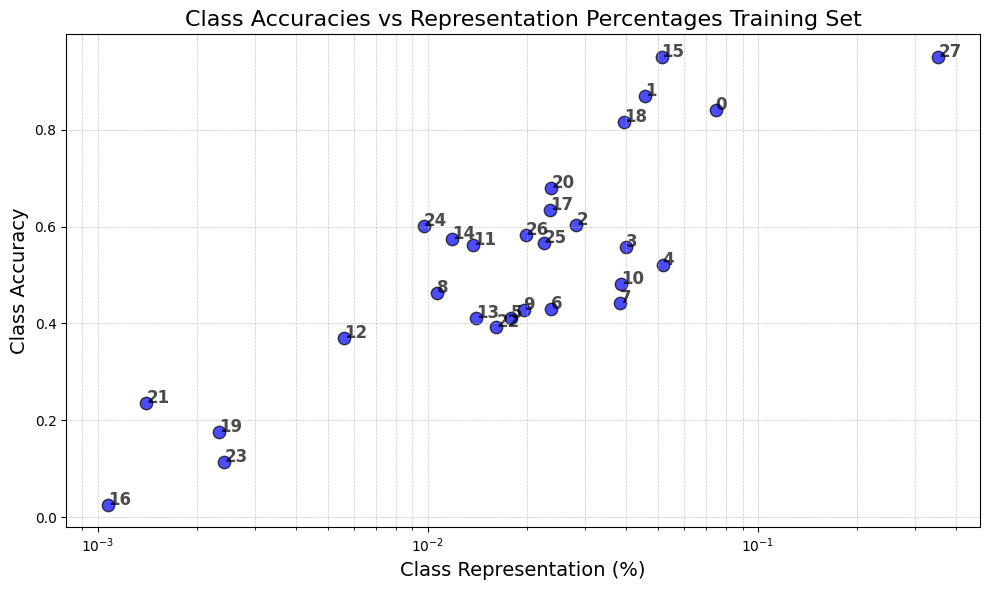

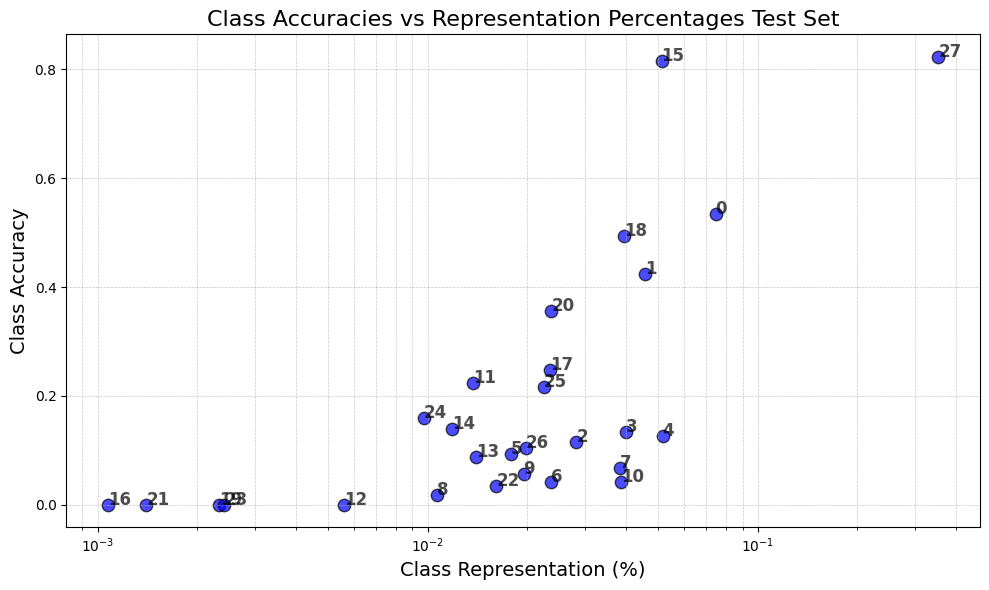

In [133]:
import matplotlib.pyplot as plt
import numpy as np

def plot_class_acc_vs_rep(x, y, title):
  model = NaiveBayes(best_laplace)
  model.fit(x_train, y_train)
  y_prob = model.predict(x)
  n_classes = len(np.unique(y))
  class_accuracies = [np.sum(y_prob[y == c] == y[y == c]) / np.sum(y == c) for c in range(n_classes)]
  class_counts = [np.sum(y_train == c) for c in range(n_classes)]
  total_samples = np.sum(class_counts)
  class_percentages = class_counts / total_samples

  plt.figure(figsize=(10, 6))
  plt.scatter(class_percentages, class_accuracies, color='blue', alpha=0.7, edgecolor='black', s=80)
  plt.xscale('log')
  plt.xlabel('Class Representation (%)', fontsize=14)
  plt.ylabel('Class Accuracy', fontsize=14)
  plt.title('Class Accuracies vs Representation Percentages ' + title, fontsize=16)
  plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

  for i, (x, y) in enumerate(zip(class_percentages, class_accuracies)):
      plt.annotate(i, (x, y), fontsize=12, fontweight='bold', alpha=0.7)

  # Show the plot
  plt.tight_layout()
  plt.show()

plot_class_acc_vs_rep(x_train, y_train, 'Training Set')
plot_class_acc_vs_rep(x_test, y_test, 'Test Set')